# Goal 
The goal of this notebook is to investigate, using simulations, the effectiveness and usefuleness of the deconfounder approach to causal inference with latent confounding in recovering the true causal effects of variables. This approach was proposed by Blei et al. in 2018 (incert reference here)

The flow of this notebook is as follows: 
- Simulate observations based on a confounded structure, where one variable confounds all but one of the other variables. 
- Simulate a continuous outcome based on a linear model, where we know the true causal effect of each variable. 
- Ommit the confounder from the dataframe, and attempt to recover it using factor models (PCA). 
- Check the recovered (substitute) confounder against the true confounder using scatter plots. 
- Re-estimate the outcome regression model, controlling for the substitute confounder instead of the true confounder, and compare the estimated coefficients on the other confounded variables against the ground truth

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

from IPython import display
import seaborn as sns

import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)


import os
os.listdir('.')

['investigating_deconfounder.py',
 'investigating_deconfounder.ipynb',
 '.gitkeep']

## Specify the assumed causal graph of the data generation process
The causal graph below represents the true data generating process that we'll be using for simulation. Notice how the confounder affects variables a, b, d, e, and f, as well as the outcome y. 

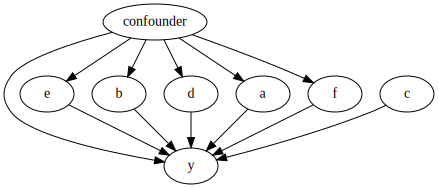

In [5]:
data_generation_graph = CausalGraphicalModel(
    nodes=['a', 'b', 'c', 'confounder',
          'd',  'e', 'f', 'y'],
    edges=[
        ("a", "y"), 
        ("b", "y"), 
        ("c", "y"), 
        ("d", "y"), 
        ("e", "y"), 
        ("f", "y"), 
        ("confounder", "y"), 
        
        
        ("confounder", "a"),
        ("confounder", "b"),
#         ("confounder", "c"),
        ("confounder", "d"),
        ("confounder", "e"),
        ("confounder", "f"),


        
        
#         ("confounder", "y"), 
#         ("confounder", "y"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
data_generation_graph.draw()

## Specifiy the paramteric relationship between the covariates. 

This is where we specify the relationship between the variables in the Causal graph above. Specifically, we have an equation that relates each two connected nodes on the graph (so an equation for each edge).

In the outcome model for y, the coefficient on each of the variables a, b, c, d, e and f represents it's $true$ causal effect. The coefficient on the confounder, however, does not represent its causal effect, because it has 5 decendents that are part of the outcome model. 

We are not ultimately interested in the causal effect of the confounder for this exercice, and instead are interested in the coefficients on each of its descendents. 

In [35]:
sample_size = 10000

confounder = np.random.normal(loc=20, scale = 10, size = sample_size)

In [36]:
a = .3*confounder + np.random.normal(loc=10,scale=3,size=sample_size)
b = -1*confounder + np.random.normal(loc=6,scale=3,size=sample_size)
c = np.random.normal(loc=15,scale=3,size=sample_size) # + .5*confounder 
d = .8*confounder + np.random.normal(loc=-10,scale=3,size=sample_size)
e = .5*confounder + np.random.normal(loc=8,scale=3,size=sample_size)
f= -.3*confounder + np.random.normal(loc=-12,scale=3,size=sample_size)


df = pd.DataFrame(np.array([a,b,c,d,e,f, confounder]).T, columns = ['a', 'b', 'c',
          'd',  'e', 'f', 'confounder'])

X_columns =['a', 'b', 'c',
          'd',  'e', 'f', 'confounder']
df = (df[X_columns] - df[X_columns].mean())/df[X_columns].std()

# df['confounder'] = confounder - confounder.mean()/confounder.std()

y = 5 + 2*df['a'] + 2*df['b'] - 5*df['c'] + 3*df['d'] + 2*df['e'] - 5*df['f'] + 7*df['confounder'] + np.random.normal(loc=0,scale=1,size=sample_size)

df['y'] = y

coeffs_true = [5,2,2,-5,3,2,-5,7]

# plt.hist(confounder, bins = 50)

# plt.hist(f, bins = 50)

In [37]:
# df = pd.DataFrame(np.array([a,b,c,d,e,f,confounder, y]).T, columns = ['a', 'b', 'c',
#           'd',  'e', 'f', 'confounder', 'y'])
df.head()

,a,b,c,d,e,f,confounder,y
0,0.370354,-0.243411,1.231799,1.335929,-0.321220,-0.214913,0.698937,8.002397
1,-0.644587,0.657208,-0.557535,-0.701374,0.016351,0.690832,-0.505772,-1.642693
2,-1.420790,-0.301604,-1.038199,0.265197,0.908398,-0.732576,0.230053,14.691396
3,-0.169094,-0.121279,-0.077559,-0.833157,-0.733397,-0.111351,-0.277532,-0.158115
4,-0.562075,0.941971,1.516784,-0.123322,-1.908355,-0.525542,-0.800229,-9.592339


In [9]:
# sns.pairplot(df, size=1.5)

## Bias from ommitting the confounder without adjustment

Here, we show that if we ommit the confounder, and attempt to estimate a new model for y, the coefficients obtained on each of the variables a, b, d, e, and f are all biased and do not represent the causal effect associated with each of those variables. The coefficient on c remains unbiased since c does not depend on the confounder. The purpose of this is to demonstrate that you indeed need to control for the confounder, or account for it somehow, if one knows you have confounded variables and is looking to assign causal interpretations to those variables

In [38]:
model_full = smf.ols("y ~ a+b+c+d+e+f + confounder", data=df)
results_full = model_full.fit()
results_df_full = pd.DataFrame(results_full.params, columns = ['estimated_params'])
results_df_full['std_errors'] = results_full.bse
results_df_full['true_params'] = coeffs_true
results_df_full

,estimated_params,std_errors,true_params
Intercept,4.986515,0.009946,5
a,1.979226,0.014037,2
b,1.991108,0.034253,2
c,-4.985279,0.009947,-5
d,3.003417,0.028061,3
e,2.012154,0.019119,2
f,-5.014175,0.014186,-5
confounder,6.966789,0.048580,7


In [39]:
model_partial = smf.ols("y ~ a+b+c+d+e+f ", data=df) ## Ommit the confounder from OLS
results_partial = model_partial.fit()
results_df_partial = pd.DataFrame(results_partial.params, columns = ['estimated_params'])
results_df_partial['std_errors'] = results_partial.bse
results_df_partial['true_params'] = coeffs_true[:-1]
results_df_partial

,estimated_params,std_errors,true_params
Intercept,4.986515,0.017393,5
a,2.385036,0.024042,2
b,-1.386356,0.043493,2
c,-4.983252,0.017395,-5
d,5.212890,0.041012,3
e,2.914761,0.031569,2
f,-5.463202,0.024194,-5


## Factor analysis: Is there evidence of latent factors?

How do we go about checking for whether a confounder exists (in this example, we know that a confounder exist since we defined the data generating process, but in the real world, the data generating process is more often than now unknown to the analyst). 

There are a multitude of tests and ways to go about answering this question. A simple, off-the-shelf check is the bartlett sphericity test, which essentially just compares the correlation matrix of our covariates to the identity matrix. This test is used to check whether our covariate space can be reduced to a lower-dimensional space of factors that explain the variation in our data. 

### Tim, this would be a good place to add your other tests. I'm thinking of the bullet points below:
- We can hypothesize a causal graph, and run conditional independence tests. 
- Prior predictive checks? 

In [18]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [19]:
chi_square_value,p_value=calculate_bartlett_sphericity(df[['a','b','c','d','e','f']])
print("Bartlett sphericity test indicates potential latent confounder, with a p-value of: ", p_value)

Bartlett sphericity test indicates potential latent confounder, with a p-value of:  0.0


In [20]:
# kmo_all,kmo_model=calculate_kmo(df[['a','b','c','d','e','f']])
# kmo_model

## Fitting a factor model using 3 PCA variations.

We fit three variations of PCA. This is not necessary indeed, but we wanted to see the robustness of our final estimates and their sensitivities to different variations of fitting the factor models. 

Notice that we use all of our X variables to fit the factor model (including variable c), consistent with the recommendation in Blei et al. 



In [40]:
X_columns_red = ['a', 'b', 'c', 'd', 'e', 'f']

In [41]:
X = np.array(df[X_columns_red])

### Using sklearn

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X)

### Using PPCA from Blei et. al's tutorial

Inferred axes:
[[ 0.7914016  -0.9305399   0.01109285  0.92619     0.89142865 -0.8071873 ]]
Standard Deviation:
[[0.00609089 0.00642342 0.00825032 0.00592227 0.00757843 0.00648691]]


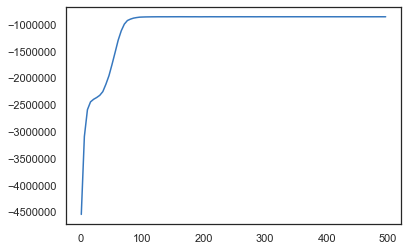

1

P-value, average:  [0.5472748135398737]


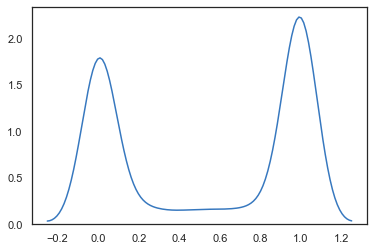

In [46]:
latent_dim = 1

confounders, holdouts, holdoutmasks, holdoutrow= confounder_ppca(holdout_portion=0.2, X=X, latent_dim=latent_dim)

holdouts_req = [holdouts]
display.display(len(holdouts_req))

confounder_req = [confounders]

n_rep = 100 # number of replicated datasets we generate
holdout_gen_util = []

for j in range(len(holdouts_req)):
    holdout_gen = np.zeros((n_rep,*(holdouts_req[j].shape)))
    
    for i in range(n_rep):
        w_sample = npr.normal(confounder_req[j][0], confounder_req[j][1])
        z_sample = npr.normal(confounder_req[j][2], confounder_req[j][3])
        
        data_dim_temp = holdouts_req[j].shape[1]
        latent_dim_temp = confounder_req[j][2].shape[1]
        num_datapoints_temp = holdouts_req[j].shape[0]
        
        with ed.interception(replace_latents(w_sample, z_sample)):
            generate = ppca_model(
                data_dim=data_dim_temp, latent_dim=latent_dim_temp,
                num_datapoints=num_datapoints_temp, stddv_datapoints=0.1, holdout_mask=holdoutmasks)

        with tf.Session() as sess:
            x_generated, _ = sess.run(generate)

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdoutmasks)
        
    holdout_gen_util.append(holdout_gen)
    
    
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll_per_zi_per_mode = []
rep_ll_per_zi_per_mode = []
stddv_datapoints=0.1
for mode in range(len(holdouts_req)):
    obs_ll = []
    rep_ll = []

    for j in range(n_eval):
        w_sample = npr.normal(confounder_req[mode][0], confounder_req[mode][1])
        z_sample = npr.normal(confounder_req[mode][2], confounder_req[mode][3])

        holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdoutmasks)
        obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1))

        rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)
    obs_ll_per_zi_per_mode.append(obs_ll_per_zi)
    rep_ll_per_zi_per_mode.append(rep_ll_per_zi)

    
pval_mode = []
for mode in range(len(holdouts_req)):
    pvals = np.array([np.mean(rep_ll_per_zi_per_mode[mode][:,i] < obs_ll_per_zi_per_mode[mode][i]) 
                      for i in range(holdouts_req[mode].shape[0])])
    holdout_subjects = np.unique(holdoutrow)
    overall_pval = np.mean(pvals[holdout_subjects])
    pval_mode.append(overall_pval)
#     print("Predictive check p-values", overall_pval)

print("P-value, average: ", pval_mode)

display.display(sns.kdeplot(pvals[holdout_subjects]))

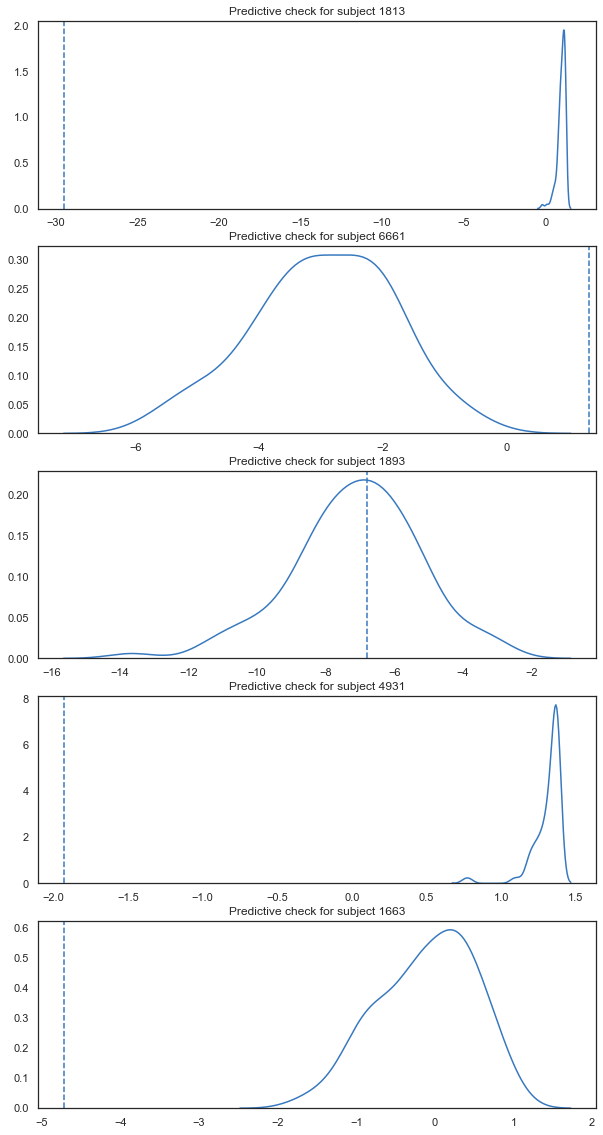

In [320]:
np.random.seed(10)

num_subjects = 5
fig, axes = plt.subplots(nrows = num_subjects, ncols=1, figsize = (10,20))

for i, ax in zip(range(num_subjects), axes.flat):
    subject_no = npr.choice(holdout_subjects) 
    sns.kdeplot(rep_ll_per_zi[:,subject_no], ax=ax).set_title("Predictive check for subject "+str(subject_no))
    ax.axvline(x=obs_ll_per_zi[subject_no], linestyle='--')

plt.show()

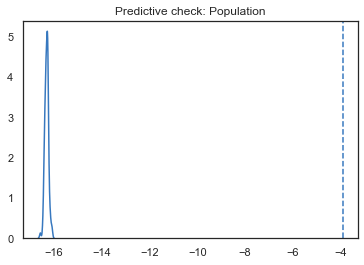

In [317]:
overall_ll_est = rep_ll_per_zi.mean(axis=1)

overall_ll_obs = obs_ll_per_zi.mean()

sns.kdeplot(overall_ll_est).set_title("Predictive check: Population")
plt.axvline(x=overall_ll_obs, linestyle='--')

In [319]:
overall_ll_est.shape

(100,)

## Visualizing the substitute confounder against the true confounder
Since we do know the values for the absolute confouder, we can actually in this case plot the recovered values against the true ones in a scatter plot and compare the fit. This is not possible in a real problem however, and we'll have to use the tests outlined in the previous sections (posterior predictive checks, etc.). 

We can see that the confounder values recovered are highly correlated with the true confounder, suggesting that we $successfully$ recovered the confounder. 

In [53]:
df['confounder_PCA_SKLEARN'] = principalComponents[:,0]

df['confounder_PPCA'] = confounders[2]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


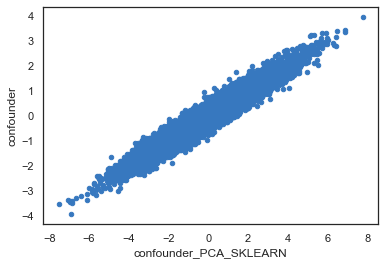

In [54]:
df.plot(kind='scatter', x = 'confounder_PCA_SKLEARN', y = 'confounder')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


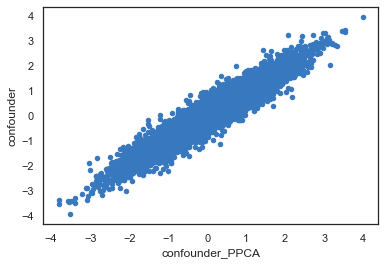

In [55]:
df.plot(kind='scatter', x = 'confounder_PPCA', y = 'confounder')

## Re-estimating regression with and without confounder

Notice that the simulation was designed such that ommitting the confounder will flip the sign of the coefficient on $b$. When we add the confounder, estimated using any PCA variation, the coefficient on $b$ remains flipped. 

In addition, the bias on the coefficient estimates on our variables of interest $a, b, d, e, and f$ did not necessarily decrease in a significant way. This is surprising, since the confounder we recovered does actually correlate very well with the true confounder. The next section explores the sensitivity of those coefficients to random noise added to the true confounder.

In [272]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true[:-1]
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003615,0.017485,5
a,2.394943,0.024413,2
b,-1.342894,0.044797,2
c,-4.981174,0.017495,-5
d,5.229357,0.041715,3
e,2.950037,0.031833,2
f,-5.459418,0.024164,-5


In [273]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_CV ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003644,0.017485,5
a,2.388504,0.025199,2
b,-1.336499,0.045224,2
c,-4.982001,0.017513,-5
d,5.222295,0.042273,3
e,2.943428,0.032471,2
f,-5.452946,0.024965,-5
confounder_PCA_CV,-0.000988,0.000958,7


In [274]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_SKLEARN ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003615,0.017485,5
a,0.839111,0.024208,2
b,0.515690,0.044638,2
c,-4.989476,0.017495,-5
d,3.395381,0.041549,3
e,1.201186,0.031634,2
f,-3.918391,0.023960,-5
confounder_PCA_SKLEARN,3.830369,0.004491,7


In [275]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PPCA ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003258,0.017481,5
a,2.330197,0.034994,2
b,-1.266551,0.053666,2
c,-4.981978,0.017493,-5
d,5.157270,0.050188,3
e,2.879609,0.041916,2
f,-5.394951,0.034743,-5
confounder_PPCA,0.304668,0.118009,7


## Adding random noise to the confounder and seeing how it affects the coefficients on the other variables

Here, we simply create a new variable, which is the original confounder plus small random noise, and substitute the true confounder with the newly created confounder in the original regression to evaluate the sensitivity of the bias of our coefficients of interest to small random deviations from the true confounder. 

We find that even with very small values of the random noise (mean of 0 and standard deviation of 0.2), we still get biased estimates of our effects of interest, especially on $b$. 

In [59]:
"""
We add random noise from a normal distribution of mean zero. We control the spread of this distribution
using the parameter 'coef', which represents the standard deviation of this normal distribution of the noise. 
"""

coef=0.2

df['confounder_2'] = df['confounder'] + coef*np.random.normal(loc=0,scale = 1, size = len(df))



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


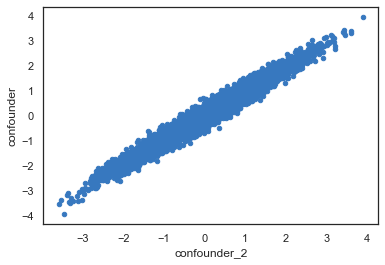

In [60]:
df.plot(kind='scatter', x = 'confounder_2', y = 'confounder')

In [61]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_2", data=df)
results_deconf = model_deconf.fit()
results_df_deconf1 = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf1['std_errors'] = results_deconf.bse
results_df_deconf1['true_params'] = coeffs_true
results_df_deconf1

,estimated_params,std_errors,true_params
Intercept,4.985151,0.013956,5
a,2.185273,0.019477,2
b,0.399365,0.042364,2
c,-4.975160,0.013958,-5
d,4.081207,0.036257,3
e,2.450162,0.026090,2
f,-5.217821,0.019692,-5
confounder_2,3.622474,0.048718,7


## Functions
Adapted from Blei et al and Alex Williams (http://alexhwilliams.info/itsneuronalblog/2018/02/26/censored-lstsq/)

In [14]:
def create_confounded_df(x, y, slope, groups):
    b = 0
    d = distance_line(b, slope, x, y)
    
    d_scaled = 0.0001 + .9999*(d-min(d))/(max(d)-min(d))
    
    df = pd.DataFrame()
    
    df['x'] = x
    df['y'] = y
    
    
    
    df['group'] = pd.Categorical(np.array([ceil(groups*(i)) for i in d_scaled]))
    
    return df
    
#     df['group'] = df['group'].astype('category')
     
    
def distance_line(b, m, x, y):
    return (y - (m*x + b))/np.sqrt(m**2 + 1)

test_df = create_confounded_df(x=a,y=y,slope=1, groups=100)

model = smf.ols("y ~ a + group", data=test_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.877e+05
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:02:49   Log-Likelihood:                -2565.3
No. Observations:               10000   AIC:                             5313.
Df Residuals:                    9909   BIC:                             5969.
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -69.0856      0.314   -219.871      0.000     -69.702     -68.470
group[T.5]       4.9242      0.444     11.083      0.000       4.053       5.795
group[T.10]     10.2790      0.385     26.713      0.000       9.525      11.033
group[T.11]     11.5120      0.385     29.919      0.000      10.758      12.266
group[T.12]     12.5229      0.444     28.185      0.000      11.652      13.394
group[T.13]     13.5554      0.351     38.591      0.000      12.867      14.244
group[T.14]     14.9562      0.363     41.228      0.000      14.245      15.667
group[T.15]     15.9529      0.363     43.972      0.000      15.242      16.664
group[T.16]     16.9385      0.351     48.224      0.000      16.250      17.627
group[T.17]     17.9005      0.351     50.959      0.000      17.212      18.589
group[T.18]     19.0647      0.351     54.274      0.000      18.376      19.753
group[T.19]     19.9255      0.351     56.727      0.000      19.237      20.614
group[T.20]     21.2282      0.333     63.706      0.000      20.575      21.881
group[T.21]     22.2527      0.344     64.657      0.000      21.578      22.927
group[T.22]     23.3907      0.328     71.280      0.000      22.747      24.034
group[T.23]     24.4005      0.330     74.048      0.000      23.755      25.046
group[T.24]     25.7138      0.326     78.866      0.000      25.075      26.353
group[T.25]     26.6569      0.321     83.129      0.000      26.028      27.286
group[T.26]     27.8038      0.321     86.628      0.000      27.175      28.433
group[T.27]     28.9001      0.320     90.199      0.000      28.272      29.528
group[T.28]     29.9184      0.319     93.670      0.000      29.292      30.545
group[T.29]     31.0295      0.318     97.653      0.000      30.407      31.652
group[T.30]     32.2609      0.319    101.281      0.000      31.637      32.885
group[T.31]     33.2856      0.317    105.053      0.000      32.665      33.907
group[T.32]     34.3870      0.316    108.721      0.000      33.767      35.007
group[T.33]     35.3481      0.316    111.703      0.000      34.728      35.968
group[T.34]     36.4573      0.316    115.297      0.000      35.837      37.077
group[T.35]     37.5603      0.316    118.979      0.000      36.942      38.179
group[T.36]     38.6384      0.316    122.368      0.000      38.020      39.257
group[T.37]     39.8392      0.315    126.290      0.000      39.221      40.458
group[T.38]     40.8950      0.315    129.738      0.000      40.277      41.513
group[T.39]     41.9715      0.315    133.144      0.000      41.354      42.589
group[T.40]     43.0631      0.315    136.669      0.000      42.445      43.681
group[T.41]     44.1456      0.315    140.151      0.000      43.528      44.763
group[T.42]     45.2069      0.315    143.497      0.000      44.589      45.824
group

In [15]:
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T



def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False, iterations = 1000):
    """Fit PCA while holding out a fraction of the dataset.
    """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
    solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(iterations):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err, M, resid

In [31]:
def confounder_ppca(X, latent_dim, holdout_portion):
    # randomly holdout some entries of X
    num_datapoints, data_dim = X.shape

    holdout_portion = holdout_portion
    n_holdout = int(holdout_portion * num_datapoints * data_dim)

    holdout_row = np.random.randint(num_datapoints, size=n_holdout)
    holdout_col = np.random.randint(data_dim, size=n_holdout)
    holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                (holdout_row, holdout_col)), \
                                shape = X.shape)).toarray()

    holdout_subjects = np.unique(holdout_row)

    x_train = np.multiply(1-holdout_mask, X)
    x_vad = np.multiply(holdout_mask, X)

    def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
        w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                    scale=tf.ones([latent_dim, data_dim]),
                    name="w")  # parameter
        z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                    scale=tf.ones([num_datapoints, latent_dim]), 
                    name="z")  # local latent variable / substitute confounder
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(ppca_model)

    latent_dim = latent_dim
    stddv_datapoints = 0.1

    model = ppca_model(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints)

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
        return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)

    def target_q(qw, qz):
        return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)


    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 500

    with tf.Session() as sess:
        sess.run(init)

        for i in range(num_epochs):
            sess.run(train)
            if i % 5 == 0:
                t.append(sess.run([elbo]))

            w_mean_inferred = sess.run(qw_mean)
            w_stddv_inferred = sess.run(qw_stddv)
            z_mean_inferred = sess.run(qz_mean)
            z_stddv_inferred = sess.run(qz_stddv)

    print("Inferred axes:")
    print(w_mean_inferred)
    print("Standard Deviation:")
    print(w_stddv_inferred)

    plt.plot(range(1, num_epochs, 5), t)
    plt.show()

    def replace_latents(w, z):

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
                rv_kwargs["value"] = w
            elif name == "z":
                rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    return [w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred], x_vad, holdout_mask, holdout_row

In [32]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, holdout_mask):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")  # (modeled) data
    return x, (w, z)




def replace_latents(w, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor

In [329]:
((npr.normal(confounder_req[mode][0], confounder_req[mode][1]))[0])

array([ 0.80884961, -0.94467516,  0.01598152,  0.92730662,  0.88753987,
       -0.79117903])

In [330]:
confounder_req[mode][0]

array([[ 0.80796325, -0.94216406,  0.00871751,  0.9259734 ,  0.8854298 ,
        -0.7887358 ]], dtype=float32)

In [335]:
np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1).shape

(10000,)

In [336]:
np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2).shape

(100, 10000)